# Telco Customer Churn – Univariate Predictor Challenge

![Churn Analysis](data/churn.png)
### Project Brief

> **Business context** – Reducing voluntary churn is a primary driver of profitability in subscription businesses.  Pinpointing the one factor that most strongly signals attrition helps the retention team focus interventions and craft targeted offers.


### The Dataset


| Attribute | Description |
|-----------|-------------|
| **File** | Telco-Customer-Churn.csv (≈ 7k rows, 21 columns) |
| **Target column** | Churn – "Yes" / "No" |
| **Identifier** | customerID (must be excluded from modelling) |
| **Predictors** | Mixed types: <br>• Demographics (gender, SeniorCitizen, Partner, Dependents)<br>• Services (InternetService, StreamingTV, …)<br>• Contract details (Contract, PaperlessBilling, PaymentMethod)<br>• Usage (tenure, MonthlyCharges, TotalCharges) |
| **Missing data** | TotalCharges contains 11 blank strings → treat as NaN |


### Learning Objectives

1. Practise **feature‑type diagnostics** and appropriate encoding (boolean, numerical, nominal, ordinal).
2. Compute **out‑of‑sample performance** via stratified 5‑fold cross‑validation.
3. Consolidate results into a tidy ranking table and extract the top scorer.


### Task Checklist

| Step | Action | Expected artefact |
|------|--------|-------------------|
| 1 | Load the CSV into a DataFrame named `telco`. | – |
| 2 | Convert `TotalCharges` to numeric, coercing errors to `NaN`, then mean‑impute. | Cleaned `telco` DataFrame |
| 3 | Map `Churn` to binary **0 = "No", 1 = "Yes"**. | `telco['Churn']` as `int` |
| 4 | Drop the `customerID` column. | – |
| 5 | Identify candidate predictors: every remaining column except `Churn`. | Python list `features` |
| 6 | For **each** feature:<br>a. Wrap with `C()` if categorical.<br>b. Fit `logit` on the training fold, predict on the validation fold.<br>c. Record the **AUC** for that fold. | List of dicts `results` |
| 7 | Compute the **mean AUC** over the 5 folds for each feature. | `all_results_df` (feature, auc) |
| 8 | Sort descending, take the top row, rename columns to `best_feature`, `best_auc`, and reset the index. | **`best_feature_df`** |

<br>

## Extension Ideas

* **Regularised Logit** – repeat the exercise with `fit_regularized` and observe whether the leader changes.
* **Alternative Metrics** – compare rankings by accuracy, F1, and Matthews CC.
* **Explainability** – draw a violin/box plot of the champion feature split by churn status to visualise separation.


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
url = "https://raw.githubusercontent.com/jhlopesalves/data-science-practice-notebook/refs/heads/main/Python/projects/telcom_customer_churn/data/Telco-Customer-Churn.csv"
telcom = pd.read_csv(url, usecols=lambda col: not col.startswith("Unnamed"))
telcom

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,...,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.5,No
7039,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.9,No
7040,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7041,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.6,Yes


In [3]:
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder

# Define columns for encoding
# binary_cols: columns with two categories (excluding the target 'Churn')
binary_cols = [
    "gender",
    "Partner",
    "Dependents",
    "PhoneService",
    "PaperlessBilling",
]
# ord_cols: columns with a natural order (here, contract duration)
ord_cols = ["Contract"]

# Container to store mappings for each encoder
encoders = {}

# 1) Encode binary columns using LabelEncoder
# This converts each category to an integer (e.g., 'Yes'/'No' → 1/0)
for col in binary_cols:
    le = LabelEncoder()
    telcom[col] = le.fit_transform(telcom[col])
    encoders[col] = dict(zip(le.classes_, le.transform(le.classes_)))

# 2) Encode ordinal columns using OrdinalEncoder
# This assigns ordered integers to each contract type
ord_enc = OrdinalEncoder(
    categories=[["Month-to-month", "One year", "Two year"]], dtype=int
)
telcom[ord_cols] = ord_enc.fit_transform(telcom[ord_cols])
encoders["Contract"] = {cat: i for i, cat in enumerate(ord_enc.categories_[0])}

# Print encoder mappings for reference
print(encoders)

{'gender': {'Female': np.int64(0), 'Male': np.int64(1)}, 'Partner': {'No': np.int64(0), 'Yes': np.int64(1)}, 'Dependents': {'No': np.int64(0), 'Yes': np.int64(1)}, 'PhoneService': {'No': np.int64(0), 'Yes': np.int64(1)}, 'PaperlessBilling': {'No': np.int64(0), 'Yes': np.int64(1)}, 'Contract': {'Month-to-month': 0, 'One year': 1, 'Two year': 2}}


In [4]:
# Create a cleaned version of the telcom DataFrame for modeling
# Drop the customerID column (identifier, not a predictor)
# Convert TotalCharges, tenure, and MonthlyCharges to numeric (coerce errors to NaN)
# Drop rows where TotalCharges is missing (after conversion)
telcom2 = (
    telcom.drop(columns=["customerID"])
    .assign(
        TotalCharges=lambda x: pd.to_numeric(x.TotalCharges, errors="coerce"),
        tenure=lambda x: pd.to_numeric(x.tenure, errors="coerce"),
        MonthlyCharges=lambda x: pd.to_numeric(x.MonthlyCharges, errors="coerce"),
    )
    .dropna(subset=["TotalCharges"])
)

In [5]:
# List of columns that represent binary features (0/1) in telcom2
binary_bool_cols = [
    "gender",
    "SeniorCitizen",
    "Partner",
    "Dependents",
    "PaperlessBilling",
    "PhoneService",
]

# Convert these columns from integer (0/1) to boolean (False/True)
# This makes downstream analysis and modeling more interpretable and consistent
telcom2[binary_bool_cols] = telcom2[binary_bool_cols].astype(bool)

In [7]:
# Define service columns that require special handling for "No phone service" and "No internet service"
service_cols_no_phone = ["MultipleLines"]
service_cols_no_internet = [
    "OnlineSecurity",
    "OnlineBackup",
    "DeviceProtection",
    "TechSupport",
    "StreamingTV",
    "StreamingMovies",
]

# Build a dictionary of replacements:
# - For MultipleLines, treat "No phone service" as "No"
# - For internet-dependent services, treat "No internet service" as "No"
replacements = {
    "MultipleLines": {"No phone service": "No"},
}
for col in service_cols_no_internet:
    replacements[col] = {"No internet service": "No"}

# Apply replacements to telcom2 DataFrame
telcom2 = telcom2.replace(replacements)

# Combine all service columns for boolean conversion
all_service_cols = service_cols_no_phone + service_cols_no_internet

# Convert "Yes"/"No" strings to boolean: True for "Yes", False otherwise
telcom2[all_service_cols] = telcom2[all_service_cols].apply(lambda col: col == "Yes")

In [8]:
# One-hot encode categorical columns: InternetService, Contract, PaymentMethod
# This creates new boolean columns for each category (except the first, due to drop_first=True)
# The original columns are removed, and new columns like InternetService_Fiber optic, Contract_One year, etc. are added
telcom2 = pd.get_dummies(
    telcom2,
    columns=["InternetService", "PaymentMethod"],
    drop_first=True,
)

In [9]:
# Map the original 'Churn' column from telcom to binary values in telcom2
# "No" becomes 0 (False), "Yes" becomes 1 (True)
# This creates a boolean target column for modeling
telcom2["Churn"] = telcom.Churn.map({"No": 0, "Yes": 1}).astype(bool)

In [10]:
X = telcom2.drop(columns=["Churn"])
y = telcom2["Churn"]

In [11]:
# Split features and target
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=42
)

In [13]:
# Build a pipeline for logistic regression with numeric feature scaling
# StandardScaler: standardizes numeric columns (mean=0, std=1)
# ColumnTransformer: applies scaling only to numeric_cols, passes other columns unchanged
# LogisticRegression: fits a classifier with balanced class weights and increased max_iter for convergence

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

numeric_cols = ["tenure", "MonthlyCharges", "TotalCharges"]

# Preprocessing: scale numeric columns, passthrough others
prepoc = ColumnTransformer(
    transformers=[("num", StandardScaler(), numeric_cols)],
    remainder="passthrough",
    verbose_feature_names_out=False,
)

# Pipeline: preprocessing + logistic regression
logreg_pipeline = Pipeline(
    steps=[
        ("pre", prepoc),
        (
            "clf",
            LogisticRegression(
                solver="lbfgs",
                max_iter=5000,
                n_jobs=-1,
                class_weight="balanced",
                random_state=42,
            ),
        ),
    ]
)

In [14]:
# Fit the logistic regression pipeline to the training data
logreg_pipeline.fit(X_train, y_train)

# Print the accuracy of the model on the test set
print("Accuracy on test set:", logreg_pipeline.score(X_test, y_test))

Accuracy on test set: 0.7229806598407281


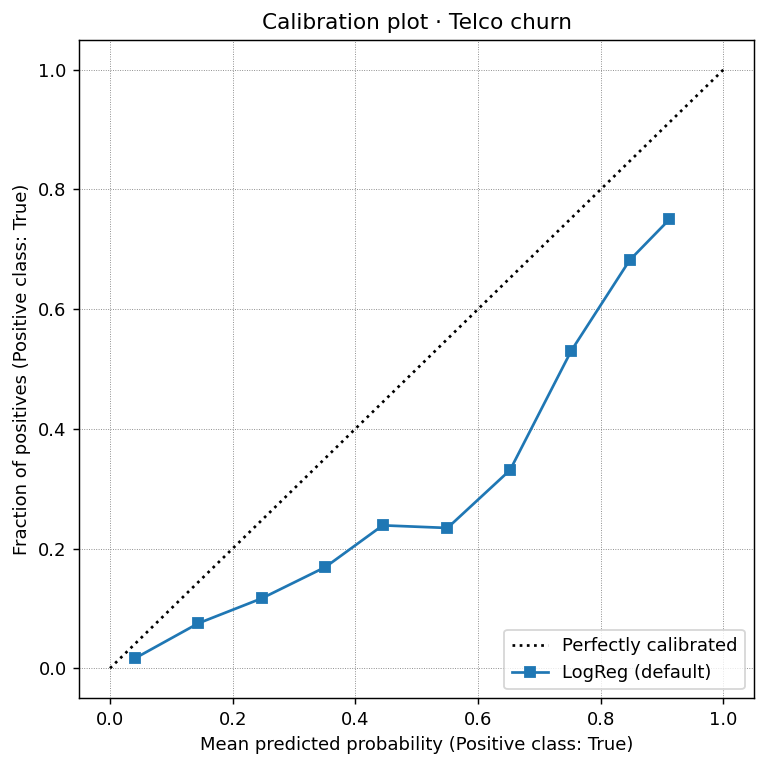

In [35]:
### Diagnostic: calibration of churn probabilities
from sklearn.calibration import CalibrationDisplay

fig, ax = plt.subplots(figsize=(6, 6), dpi=130)

CalibrationDisplay.from_estimator(
    logreg_pipe,  # use your fitted Pipeline
    X_test,
    y_test,
    n_bins=10,
    ax=ax,
    name="LogReg (default)",
)

ax.set_title("Calibration plot · Telco churn")
ax.grid(True, color="grey", ls=":", lw=0.5)
fig.tight_layout()
plt.show()

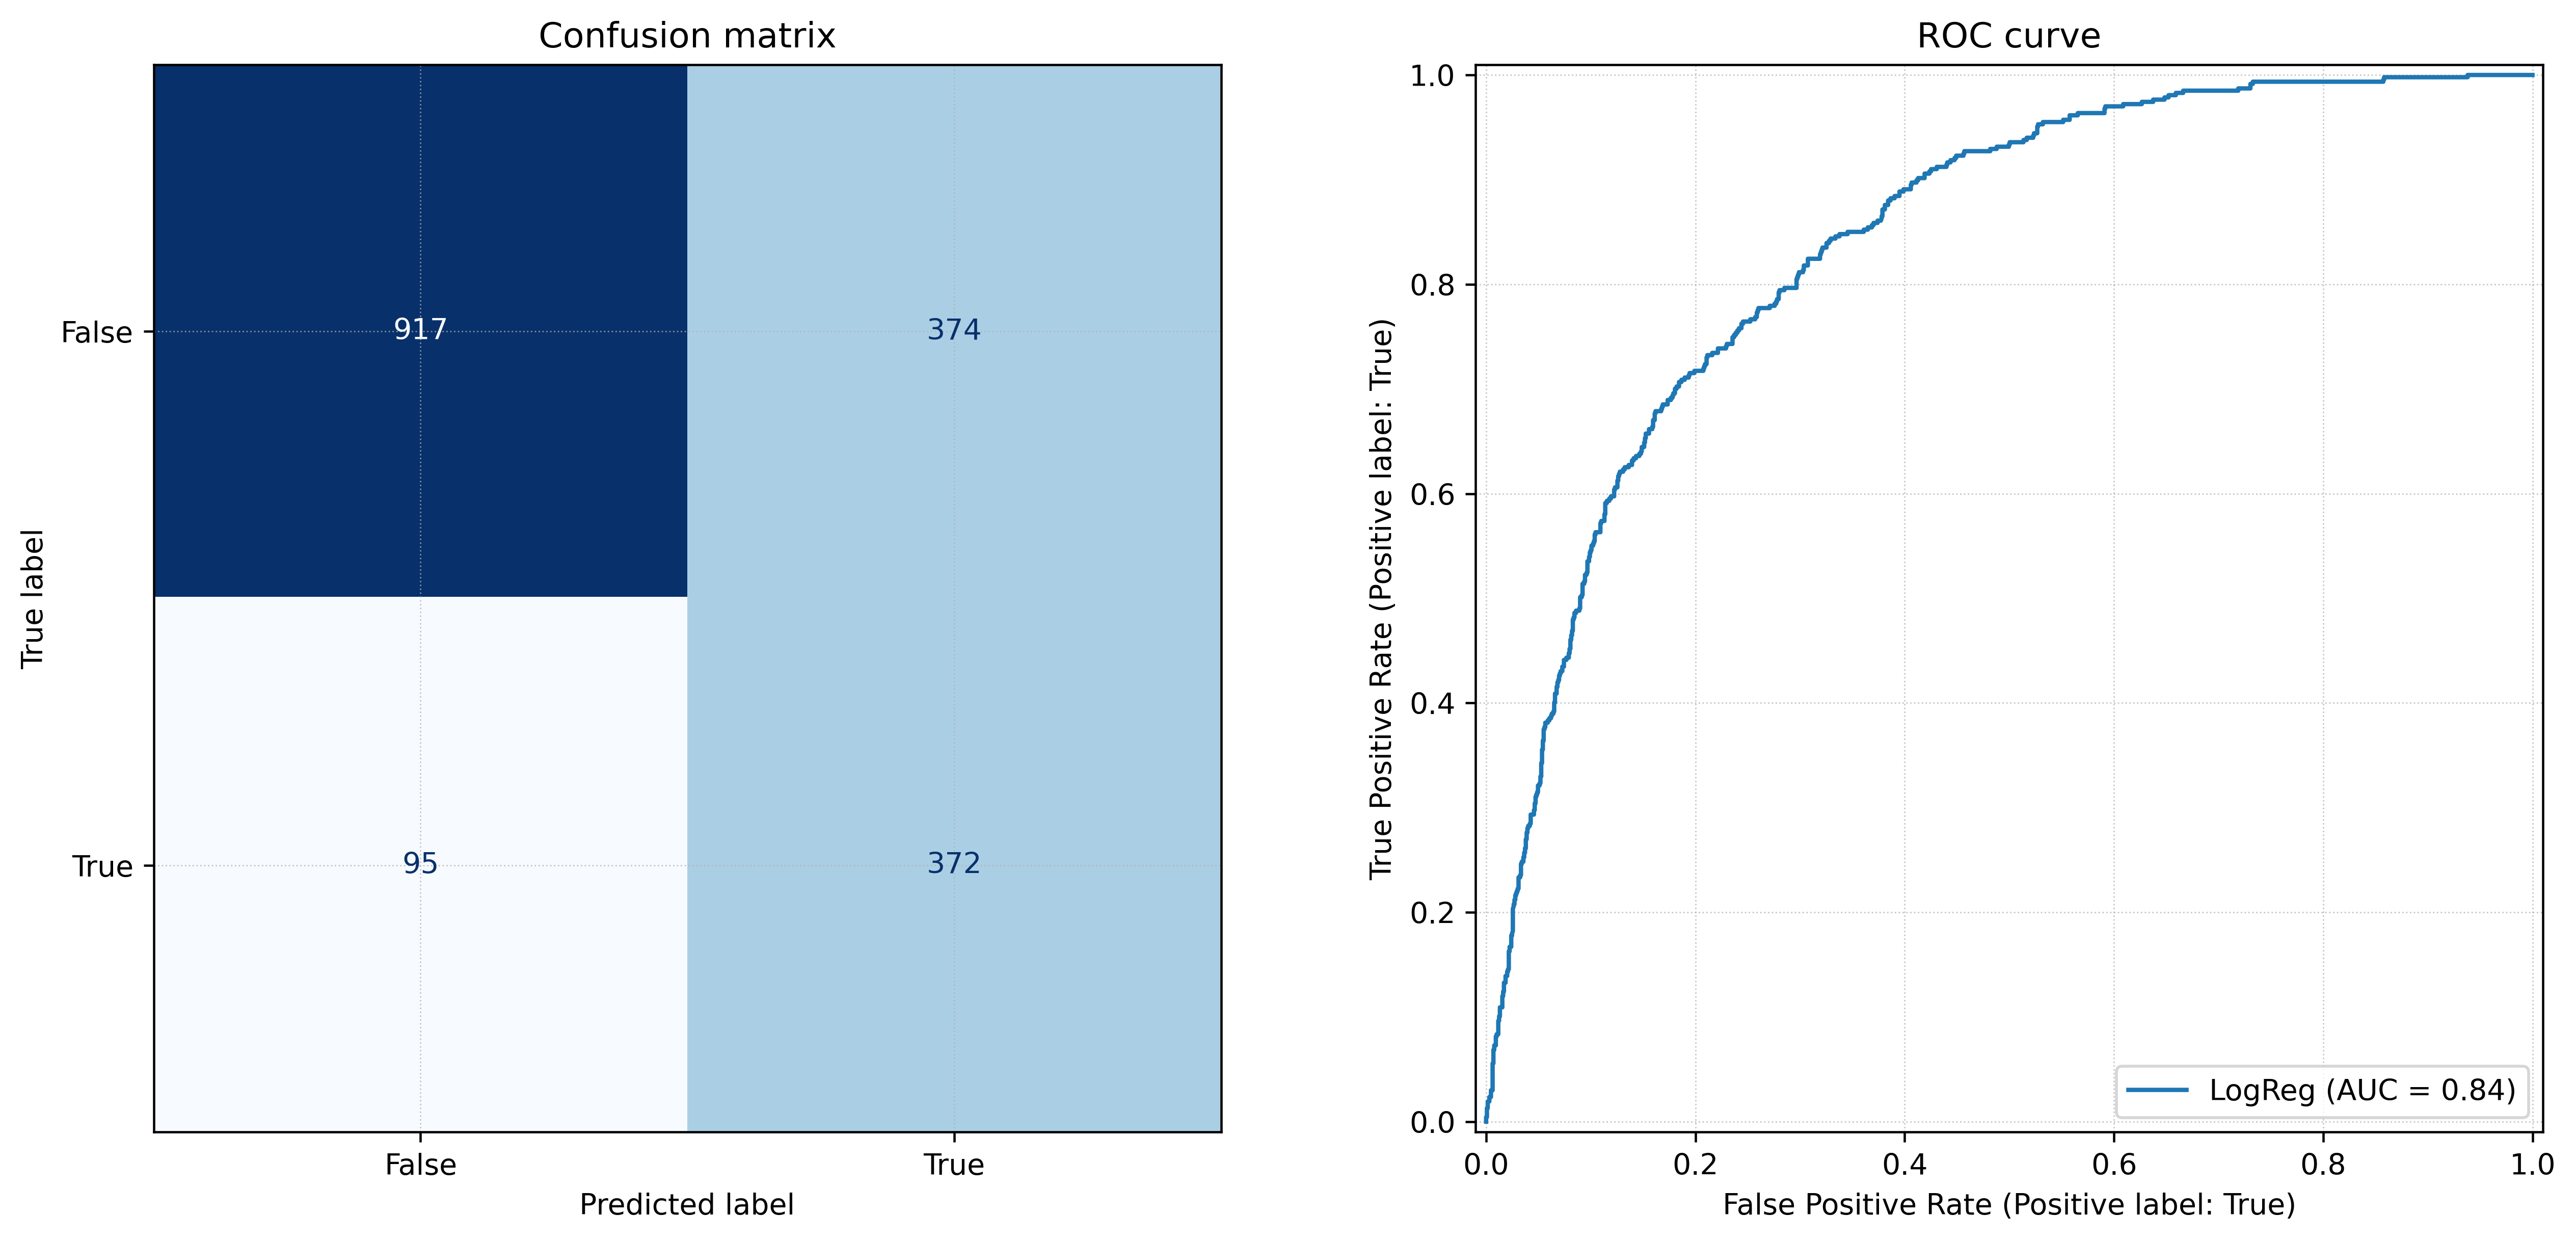

In [32]:
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay

# Create a figure with two subplots: one for the confusion matrix, one for the ROC curve
fig, (ax_cm, ax_roc) = plt.subplots(1, 2, figsize=(13, 6), dpi=410)

# Plot the confusion matrix for the test set predictions
ConfusionMatrixDisplay.from_estimator(
    logreg_pipe,  # fitted classifier pipeline
    X_test,  # test features
    y_test,  # test labels
    ax=ax_cm,  # axis for confusion matrix
    cmap="Blues",  # color map
    colorbar=False,  # no colorbar
)

# Plot the ROC curve for the test set predictions
RocCurveDisplay.from_estimator(
    logreg_pipe,  # fitted classifier pipeline
    X_test,  # test features
    y_test,  # test labels
    ax=ax_roc,  # axis for ROC curve
    name="LogReg",  # legend label
)

# Set subplot titles
ax_cm.set_title("Confusion matrix")
ax_roc.set_title("ROC curve")

# Add grid to both plots for readability
for ax in (ax_cm, ax_roc):
    ax.grid(ls=":", lw=0.5, alpha=0.7)

fig.tight_layout()
plt.show()

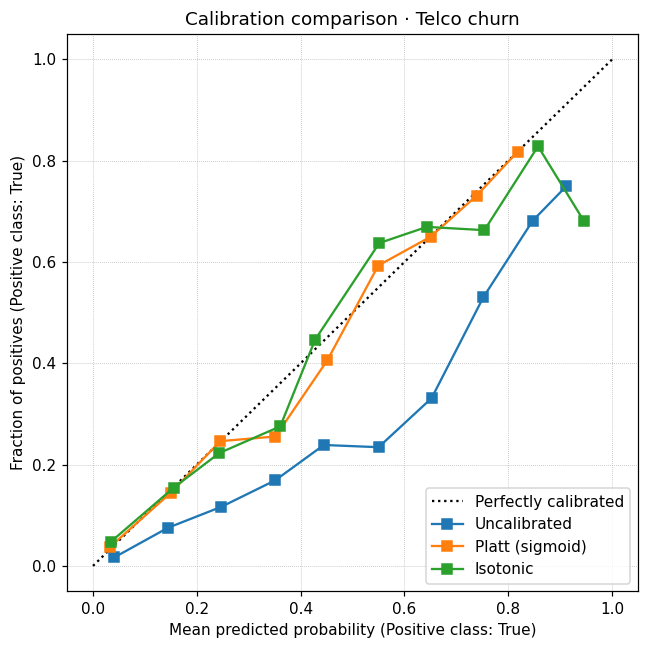

In [38]:
# Probability calibration
from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

# Increase max_iter to ensure convergence
base_lr = LogisticRegression(max_iter=5000)

platt = CalibratedClassifierCV(estimator=base_lr, method="sigmoid", cv=5)
iso = CalibratedClassifierCV(estimator=base_lr, method="isotonic", cv=5)

platt.fit(X_train, y_train)
iso.fit(X_train, y_train)

fig, ax = plt.subplots(figsize=(6, 6), dpi=110)

CalibrationDisplay.from_estimator(
    logreg_pipe, X_test, y_test, n_bins=10, name="Uncalibrated", ax=ax
)
CalibrationDisplay.from_estimator(
    platt, X_test, y_test, n_bins=10, name="Platt (sigmoid)", ax=ax
)
CalibrationDisplay.from_estimator(
    iso, X_test, y_test, n_bins=10, name="Isotonic", ax=ax
)

ax.set_title("Calibration comparison · Telco churn")
ax.grid(ls=":", lw=0.5)
fig.tight_layout()
plt.show()